# Generic Pseudo-labeling for Domain Adaptation in Deep Computer Vision

## Modern Office Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import lib.data
import lib.torch_train_eval
import lib.adaptive_train_eval

import tasks.preprocessing
import tasks.utils
import tasks.results

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output/office"

RANDOM_SEED = 42
BATCH_SIZE = 1
PRINT_STATS_PERIOD = 500

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

RHO = 4
SAMPLING_PERIOD = 20


FINETUNED_SOURCE__MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
FINETUNED_TARGET_MODEL_DIR = os.path.join(OUTPUT_DIR, "target_classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-20")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-20")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-10")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-10")

FINETUNE_SOURCE_MODEL = False
FINETUNE_TARGET_MODEL = True
TRAIN_UNSUPERVISED_MODEL = False
FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
TRAIN_SEMI_SUPERVISED_MODEL_20 = False
FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
TRAIN_SEMI_SUPERVISED_MODEL_10 = False

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset preprocessing

In [ ]:
source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = (
    lib.data.train_val_test_split(
        source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

source_train_loader = tasks.preprocessing.single_batch_loader(
    source_train_dataset, shuffle=True
)
source_val_loader = tasks.preprocessing.single_batch_loader(
    source_val_dataset, shuffle=False
)
source_test_loader = tasks.preprocessing.single_batch_loader(
    source_test_dataset, shuffle=False
)

In [ ]:
target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=source_dataset.label_encoder,  # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = (
    lib.data.train_val_test_split(
        target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

target_train_loader = tasks.preprocessing.single_batch_loader(
    target_train_dataset, shuffle=True
)
target_val_loader = tasks.preprocessing.single_batch_loader(
    target_val_dataset, shuffle=False
)
target_test_loader = tasks.preprocessing.single_batch_loader(
    target_test_dataset, shuffle=False
)

In [ ]:
unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
unlabeled_dataset_20.load_from_image_dataset(target_train_dataset)

to_be_unlabeled_dataset_20, labeled_dataset_20 = lib.data.stratified_split(
    target_train_dataset, test_size=0.2
)

unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_20.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_20.load_from_image_dataset(to_be_unlabeled_dataset_20)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_20.add(sample_img, sample_label)

len(labeled_dataset_20), len(source_train_dataset)

In [ ]:
to_be_unlabeled_dataset_10, labeled_dataset_10 = lib.data.stratified_split(
    target_train_dataset, test_size=0.1
)

unlabeled_dataset_10 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_10.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_10.load_from_image_dataset(to_be_unlabeled_dataset_10)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_10.add(sample_img, sample_label)

len(labeled_dataset_10), len(source_train_dataset)

In [ ]:
class_names = source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(source_train_dataset.label_encoder.classes_)
}

### Source-only model

In [ ]:
import torchinfo


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
#https://arxiv.org/pdf/2405.13698
# disable lr for adam
exp_lr_scheduler = None


torchinfo.summary(tasks.utils.get_model(device=device), input_size=(BATCH_SIZE, 3, 1500, 1500))

In [ ]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SOURCE_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_SOURCE__MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=5,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Target only model

In [ ]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(encodings))

if FINETUNE_TARGET_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=10e-3)

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        target_train_loader,
        target_val_loader,
        output_dir=FINETUNED_TARGET_MODEL_DIR,
        num_epochs=100,
        patience=10,
        warmup_period=25,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=20000,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Unsupervised Domain Adaptation

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af

https://stats.stackexchange.com/questions/364584/why-does-using-pseudo-labeling-non-trivially-affect-the-results

https://www.sciencedirect.com/science/article/abs/pii/S1077314222001102

In [ ]:
model = tasks.utils.get_model(device=device)

if TRAIN_UNSUPERVISED_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(UNSUPERVISED_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())
    
    source_history = tasks.utils.try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "source_history.pickle"))
    target_history = tasks.utils.try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "target_history.pickle"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 20% target data

In [ ]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_20, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=history
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(device=device)

if TRAIN_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    source_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "source_history.pickle"))
    target_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "target_history.pickle"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.single_batch_loader(
                dataset, sampler=sampler, shuffle=False
            ),
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 10% target data

In [ ]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_10, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=None,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(device=device)

if TRAIN_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    source_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10, "source_history.pickle"))
    target_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10, "target_history.pickle"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_10,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_10,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=None,
            previous_target_history=None,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

## MNIST/MNIST-M dataset

In [2]:
BATCH_SIZE = 16
WEIGHT_DECAY = 10e-6
RHO = 3

AD_DATA_DIR = "data/digits"
AD_OUTPUT_DIR = "output/digits"

AD_SOURCE_DATASET = "mnist"
AD_TARGET_DATASET = "mnist-m"

AD_FINETUNED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "classifier")
AD_FINETUNED_TARGET_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "target_classifier")
AD_UNSUPERVISED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "unsupervised")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-20")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-20")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-10")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-10")

AD_FINETUNE_MODEL = False
AD_FINETUNE_TARGET_MODEL = False
AD_TRAIN_UNSUPERVISED_MODEL = False
AD_FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
AD_TRAIN_SEMI_SUPERVISED_MODEL_20 = False
AD_FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
AD_TRAIN_SEMI_SUPERVISED_MODEL_10 = False

### Dataset preprocessing

In [3]:
ad_source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_source_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_SOURCE_DATASET))

ad_source_train_dataset, ad_source_val_dataset, ad_source_test_dataset = (
    lib.data.train_val_test_split(
        ad_source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

ad_source_train_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
ad_source_val_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
ad_source_test_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
ad_target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=ad_source_dataset.label_encoder,  # use same classes
)
ad_target_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_TARGET_DATASET))

ad_target_train_dataset, ad_target_val_dataset, ad_target_test_dataset = (
    lib.data.train_val_test_split(
        ad_target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

ad_target_train_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
ad_target_val_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
ad_target_test_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
ad_unlabeled_dataset = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_unlabeled_dataset.load_from_image_dataset(ad_target_train_dataset)

In [6]:
ad_to_be_unlabeled_dataset_10, ad_labeled_dataset_10 = lib.data.stratified_split(
    ad_target_train_dataset, test_size=0.1
)

ad_unlabeled_dataset_10 = lib.data.UnlabeledImageDataset(
    parser_func=ad_labeled_dataset_10.parser_func,
    preprocessing_func=ad_source_dataset.preprocessing_func,
)
ad_unlabeled_dataset_10.load_from_image_dataset(ad_to_be_unlabeled_dataset_10)

# combine data from both domain and target datasets
for sample_img, sample_label in ad_source_train_dataset.samples:
    ad_labeled_dataset_10.add(sample_img, sample_label)

len(ad_labeled_dataset_10), len(ad_source_train_dataset)

(57196, 52500)

In [7]:
ad_unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_unlabeled_dataset_20.load_from_image_dataset(ad_target_train_dataset)

ad_to_be_unlabeled_dataset_20, ad_labeled_dataset_20 = lib.data.stratified_split(
    ad_target_train_dataset, test_size=0.2
)

ad_unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=ad_labeled_dataset_20.parser_func,
    preprocessing_func=ad_labeled_dataset_20.preprocessing_func,
)
ad_unlabeled_dataset_20.load_from_image_dataset(ad_to_be_unlabeled_dataset_20)

# combine data from both domain and target datasets
for sample_img, sample_label in ad_source_train_dataset.samples:
    ad_labeled_dataset_20.add(sample_img, sample_label)

len(ad_labeled_dataset_20), len(ad_source_train_dataset)

(61892, 52500)

In [8]:
class_names = ad_source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(ad_source_train_dataset.label_encoder.classes_)
}

### Source-only model

In [9]:
import torchinfo


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
#https://arxiv.org/pdf/2405.13698
# disable lr for adam
exp_lr_scheduler = None


torchinfo.summary(tasks.utils.get_model(device=device,
                                        replace_fc_layer=True,
                                        num_classes=len(encodings)),
                                        input_size=(BATCH_SIZE, 3, 30, 30))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 10]                  --
├─Conv2d: 1-1                            [16, 64, 15, 15]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 15, 15]          128
├─ReLU: 1-3                              [16, 64, 15, 15]          --
├─MaxPool2d: 1-4                         [16, 64, 8, 8]            --
├─Sequential: 1-5                        [16, 64, 8, 8]            --
│    └─BasicBlock: 2-1                   [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [16, 64, 8, 8]            --
│

In [ ]:
model = tasks.utils.get_model(device=device,
                            replace_fc_layer=True,
                            num_classes=len(encodings),
                            use_default_weights=False)

if AD_FINETUNE_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        ad_source_train_loader,
        ad_source_val_loader,
        output_dir=AD_FINETUNED_MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=1,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))

In [ ]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Target only model

In [ ]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(encodings))

if  AD_FINETUNE_TARGET_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        ad_target_train_loader,
        ad_target_val_loader,
        output_dir=AD_FINETUNED_TARGET_MODEL_DIR,
        num_epochs=15,
        patience=3,
        warmup_period=1,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_TARGET_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

### Unsupervised Domain Adaptation

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_TRAIN_UNSUPERVISED_MODEL:
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_source_train_dataset,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, AD_UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Semi Supervised 10%

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_FINETUNE_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            ad_labeled_dataset_10, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=ad_source_val_loader,
        output_dir=AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10,
        num_epochs=25,
        patience=5,
        warmup_period=1,
        previous_history=history,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_TRAIN_SEMI_SUPERVISED_MODEL_10:
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_labeled_dataset_10,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset_10,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(
        model, AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10
    )
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Supervised 20%

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_FINETUNE_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            ad_labeled_dataset_20, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=ad_source_val_loader,
        output_dir=AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20,
        num_epochs=25,
        patience=5,
        warmup_period=1,
        previous_history=history,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

In [10]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(encodings)
)

if AD_TRAIN_SEMI_SUPERVISED_MODEL_20:
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_labeled_dataset_20,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset_20,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(
        model, AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20
    )
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


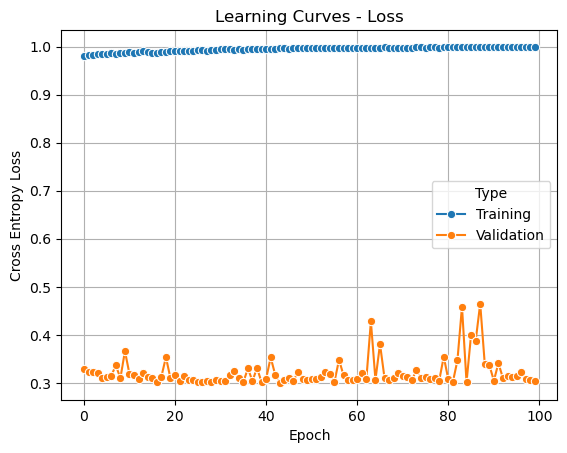

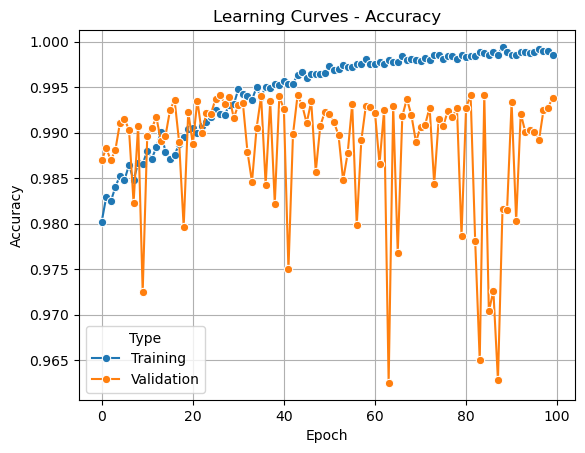

In [11]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

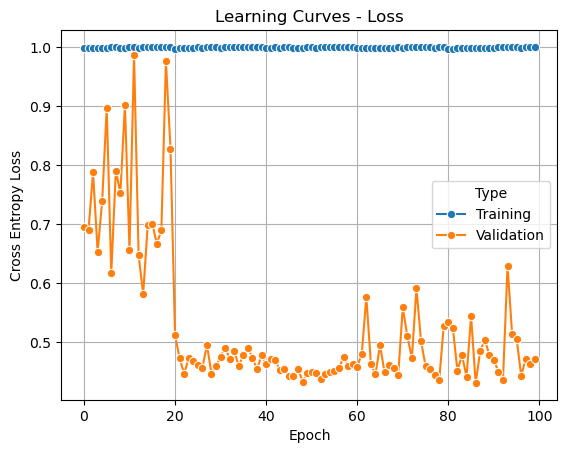

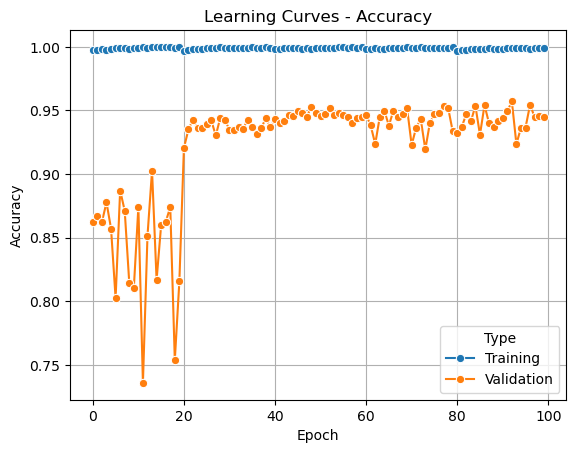

In [12]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

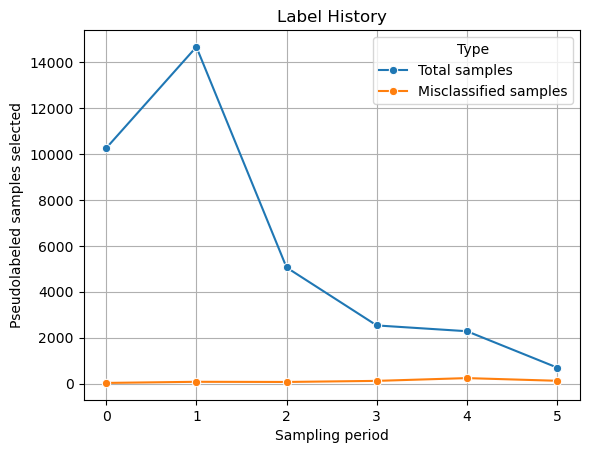

In [13]:
tasks.results.plot_label_history(label_history, encodings)

  0%|          | 0/629 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1004
           1       0.95      0.97      0.96      1116
           2       0.94      0.95      0.95      1018
           3       0.98      0.83      0.90      1041
           4       0.96      0.93      0.94       961
           5       0.90      0.96      0.93       912
           6       0.92      0.97      0.94       969
           7       0.89      0.97      0.93      1061
           8       0.87      0.95      0.91       998
           9       0.97      0.81      0.89       983

    accuracy                           0.93     10063
   macro avg       0.93      0.93      0.93     10063
weighted avg       0.93      0.93      0.93     10063



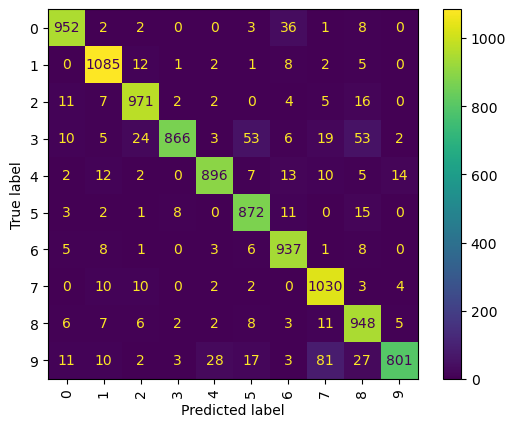

In [14]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)